# COMP 755

Plan for today

1. Review multi-class logistic regression
2. Look at an example of online learning
3. Multivariate Gaussian distribution
4. Generative models
5. Naive Bayes


$$
\renewcommand{\xx}{\mathbf{x}}
\renewcommand{\yy}{\mathbf{y}}
\renewcommand{\zz}{\mathbf{z}}
\renewcommand{\vv}{\mathbf{v}}
\renewcommand{\bbeta}{\boldsymbol{\mathbf{\beta}}}
\renewcommand{\mmu}{\boldsymbol{\mathbf{\mu}}}
\renewcommand{\ssigma}{\boldsymbol{\mathbf{\sigma}}}
\renewcommand{\reals}{\mathbb{R}}
\renewcommand{\loglik}{\mathcal{LL}}
\renewcommand{\penloglik}{\mathcal{PLL}}
\renewcommand{\likelihood}{\mathcal{L}}
\renewcommand{\Data}{\textrm{Data}}
\renewcommand{\given}{ \big| }
\renewcommand{\MLE}{\textrm{MLE}}
\renewcommand{\tth}{\textrm{th}}
\renewcommand{\Gaussian}[2]{\mathcal{N}\left(#1,#2\right)}
\renewcommand{\norm}[1]{\left\lVert#1\right\rVert}
\renewcommand{\ones}{\mathbf{1}}
\renewcommand{\diag}[1]{\textrm{diag}\left( #1 \right)}
\renewcommand{\sigmoid}[1]{\sigma\left(#1\right)}
\renewcommand{\myexp}[1]{\exp\left\{#1\right\}}
\renewcommand{\mylog}[1]{\log\left\{#1\right\}}
$$

In [1]:
import numpy
import matplotlib.pyplot as plt
% matplotlib inline
# plotting 
def draw_line(w,b,c='k',linewidth=1):
    if numpy.abs(w[1]) > numpy.abs(w[0]):
        y1 = -(1.0*w[0] + b)/w[1]
        y0 = -b/w[1]
        x1 = 1
        x0 = 0
    else:
        x1 = -(1.0*w[1] + b)/w[0]
        x0 = -b/w[0]
        y1 = 1
        y0 = 0

    h = plt.plot([x0,x1],[y0,y1],
                 c,alpha=1.0,
                 linewidth=linewidth)
    plt.xlim([0,1])
    plt.ylim([0,1])
    return h

hs = []
def add_to_plot(sample,w,b):
    xi,yi = sample
    pt = plt.annotate(str(int(yi)),xy = xi,
                 alpha=1.0,
                 horizontalalignment='center', 
                 verticalalignment='center')
    h, = draw_line(w,b)
    
    for other in hs:
        other.set_alpha(0.99*other.get_alpha())
    hs.append(h)
    hs.append(pt)


# Log-Likelihood

1. There are $N$ samples, each in one of $C$ classes, and $p$ features
2. Labels are represented using one-hot vectors $y_i$
3. Feature matrix $X$ contains a column of 1s -- corresponding to the bias term.
4. First row of weight matrix $B$ are bias terms.
5. $\bbeta_{k}$ is $k^\tth$ column of matrix $B$

|   |Variable   |Dimensions |
|---|:---:|:-----:|
|feature matrix| $X$ | $N\times (p+1)$ |
| label matrix |$Y$ | $N\times C$| 
| weight matrix| $B$ | $(p+1)\times C$|



Likelihood is 
$$
\likelihood(B\given Y,X) = \underbrace{\prod_{i=1}^N}_{\textrm{samples}}\underbrace{\prod_{c=1}^C}_{\textrm{classes}}\left[\frac{ \myexp{\xx_i^T\bbeta_c}}{\sum_{k=1}^C\myexp{\xx_i^T\bbeta_k}}\right]^{y_{i,c}}
$$
Log-likelihood is
$$
\loglik(\beta_0,B\given Y,X) = \sum_{i=1}^N
\sum_{c=1}^C y_{i,c}\left(\xx_i^T\bbeta_c - \mylog{\sum_{k=1}^C\myexp{\xx_i^T\bbeta_k}} \right)
$$



# Ridge regularized log-likelihood


Ridge regularized log-likelihood
$$
\begin{aligned}
\penloglik(B\given Y,X) =& \sum_{i=1}^N
\sum_{c=1}^C y_{i,c}\left(\xx_i^T\bbeta_c - \mylog{\sum_{k=1}^C\myexp{\xx_i^T\bbeta_k}} \right)\\ &- \frac{\lambda}{2}\sum_{k=1}^C \sum_{j=1}^p \beta_{j,k}^2
\end{aligned}
$$

Note that we keep the last column of $B$ fixed at 0 to get rid of excess parameters. 

These parameters will not contribute to the regularization -- sum of their squares is 0.




# Gradients of multi-class logistic regression likelihood
Using
$$
\mu_{i,l} = \frac{\myexp{\xx_i^T\bbeta_l}}{\sum_{k=1}^C\myexp{\xx_i^T\bbeta_k}},
$$
partial derivatives are
$$
\frac{\partial}{\partial\beta_{j,l}} \loglik(B) = \sum_i \underbrace{x_{i,j}}_{\textrm{feature $j$}}\underbrace{(y_{i,l} - \mu_{i,l})}_{\textrm{residual in predicting class $l$}} = \xx_{:,j}^T(\yy_{:,l} - \mu_{:,l}),
$$
gradient of log likelihood with respect to a column of $B$
$$
\nabla_{\beta_c} \loglik(B) = \sum_i (y_{i,c} - \mu_{i,c})\xx_i,
$$
and gradient of ridge regularized log-likelihood with respect to a column of $B$
$$
\nabla_{\beta_c} \penloglik(B) = \sum_i (y_{i,c} - \mu_{i,c})\xx_i - \lambda\left[\begin{aligned}0\\\ones_p\end{aligned}\right]
$$

[ 2.94467154  3.2747466 ] -3.13538881976


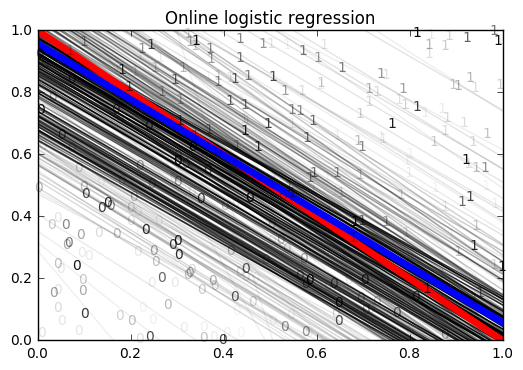

In [326]:
# A simple example of online learning

# sample_generator generates a sample at a time
# if you are curious about what is going on here
# read about python generators.
def sample_generator(N,true_w,true_b):
    true_w = numpy.asarray(true_w)
    d = len(true_w)
    for i in range(N):
        x = numpy.random.rand(d)
        y = float((numpy.dot(x,true_w) + true_b) > 0)
        yield x,y

def update(w,b,sample,it):
    xi,yi = sample
    v = numpy.exp(numpy.dot(xi.transpose(),w) + b)
    res = yi - v/(1.0 + v)
    gw = res*xi  
    gb = res
    # step size diminishes with iterations
    step = 1.0/(it**0.25)
    w = w + step*gw
    b = b + step*gb
    return w,b

numpy.random.seed(2)
# synthetic data generator for illustration purposes    
true_w = [1.0,1.0]
true_b = -1.0
N = 300
data_stream = sample_generator(N,true_w,true_b)


# actual fitting of the parameters
# initialization
w = numpy.asarray([-0.1,-0.2])
b = 0.05
it = 0

# while more data is available
while True:
    try:
        (xi,yi) = data_stream.next()
        it += 1    
        w,b = update(w,b,(xi,yi),it)
        add_to_plot((xi,yi),w,b)
    except StopIteration:
        # no more data
        break
        
draw_line(true_w,true_b,'r',linewidth=5)
draw_line(w,b,'b',linewidth=5)

plt.title('Online logistic regression')

print w,b


# Online learning and Stochastic Gradient Descent (SGD)

Samples are delivered in small mini-batches

Parameters are updated using gradient computed on the single most recent sample.

Mini-batch gradients are noisy compared to the gradient on the whole data batch.
Hence the name **stochastic gradient ascent/descent**.

Sophisticated SGD schemes involve use of momentum -- averaging of gradients seen thus far.

Typically SGD used in large data settings, where processing whole batch of data is expensive.




# Linear transformations

We are going to review some of the linear algebra/analytic geometry

We will look at examples in 2D, $\xx \in \reals^2$, and use $2 \times 2$ matrices.




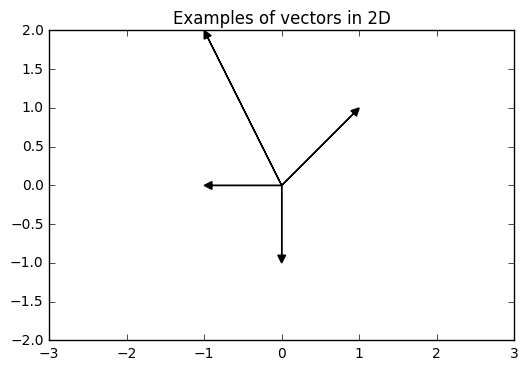

In [327]:
import numpy
import matplotlib.pyplot as plt

def draw_vector(zz,color='k',label=None):
    z1 = zz[0]
    z2 = zz[1]
    length = numpy.sqrt(z1**2+z2**2)
    head_length = 0.1*numpy.min([length,1.0])
    z1 = z1 - z1/length*head_length
    z2 = z2 - z2/length*head_length
    plt.arrow(0,0,z1,z2,ec=color,fc=color,
              head_length=head_length,head_width=0.1)    
    if not label is None:
        plt.annotate(label,(z1,z2))

draw_vector([1.0,1.0])
draw_vector([-1.0,2.0])
draw_vector([-1.0,0])
draw_vector([0,-1.0])
plt.axis('equal')
plt.xlim([-3,3])
plt.ylim([-3,3])
plt.title('Examples of vectors in 2D');

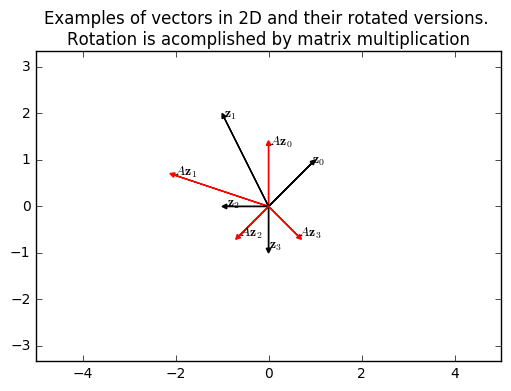

In [290]:
def illustrate_linear_transformation(A,Z):
    for i in range(Z.shape[1]):
        zz = Z[:,i]
        draw_vector(zz,label='$\mathbf{z}_'+str(i)+'$')        
        xx = numpy.dot(A,zz) # perform linear transformation
        draw_vector(xx,'r',label='$A\mathbf{z}_'+str(i) + '$')
        
    plt.axis('equal')
    plt.axis([-5,5,-5,5])
    

Z = numpy.asarray([[1.0,-1.0,-1.0, 0.0],
                   [1.0, 2.0, 0.0,-1.0]])    
        
theta = 2.0*numpy.pi/8.0
A = numpy.asarray([[numpy.cos(theta), -numpy.sin(theta)],
                   [numpy.sin(theta), numpy.cos(theta)]])

illustrate_linear_transformation(A,Z)

plt.title(('Examples of vectors in 2D and their rotated versions. \n'+ 
          'Rotation is acomplished by matrix multiplication'));

Transformed vectors:
[[ 1.5   1.5  -0.5  -1.  ]
 [ 2.25  2.25 -0.75 -1.5 ]]


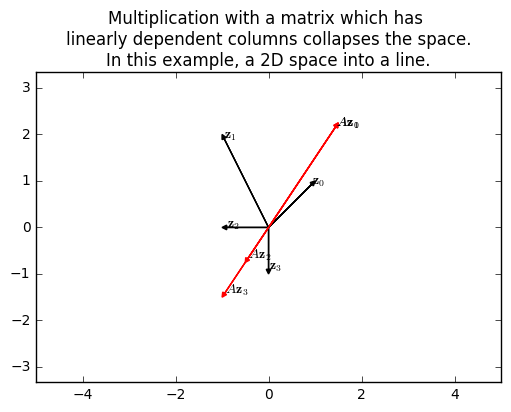

In [329]:
Z = numpy.asarray([[1.0,-1.0,-1.0, 0.0],
                    [1.0, 2.0, 0.0,-1.0]])    
    
A = numpy.asarray([[0.5 ,1.0],
                   [0.75,1.5]])

print "Transformed vectors:"
print numpy.dot(A,X)

illustrate_linear_transformation(A,Z)
plt.title(('Multiplication with a matrix which has \n'+
           'linearly dependent columns collapses the space.\n' + 
           'In this example, a 2D space into a line.'));

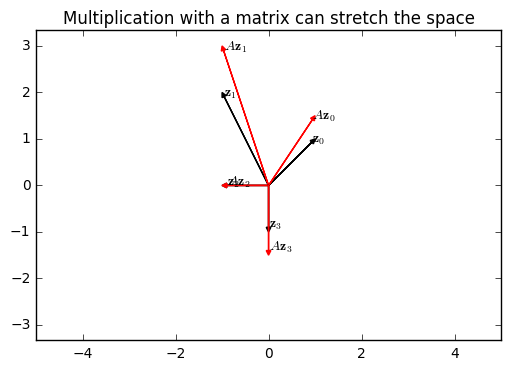

In [292]:
A = numpy.asarray([[1.0,0.0],
                   [0.0,1.5]])
Z = numpy.asarray([[1.0,-1.0,-1.0, 0.0],
                   [1.0, 2.0, 0.0,-1.0]])

illustrate_linear_transformation(A,Z)
plt.title('Multiplication with a matrix can stretch the space');


# Eigenvectors and eigenvalues

For a linear transformation represented by matrix $A$, $\xx$ is an **eigenvector** if it is non-zero and
$$
A\xx = \lambda \xx
$$
$\lambda$ is called **eigenvalue**.

In practice an eigenvector will be of length $1$ $\norm{\xx} = \sqrt{\sum_i x_i^2} = 1$.
You can interpret it as direction along which space gets scaled by $\lambda$

Matrix 
$$
A = \begin{bmatrix} 1.0 & 0.0 \\
0.0 & 2.0 \\
\end{bmatrix}
$$
has eigenvectors $\xx_1 = \begin{bmatrix}1.0\\0.0\end{bmatrix}$ and $\xx_2 = \begin{bmatrix} 0.0 \\ 1.0 \end{bmatrix}$, with corresponding eigenvalues $\lambda_1 = 1.0$ and $\lambda_2 = 2.0$.

Eigenvectors
[[ 0.96391077 -0.67879055]
 [ 0.26622551  0.73433194]]
Eigenvalues
[-0.11043782 -1.10043765]


array([[ -5.55111512e-17,  -2.22044605e-16],
       [  0.00000000e+00,   1.11022302e-16]])

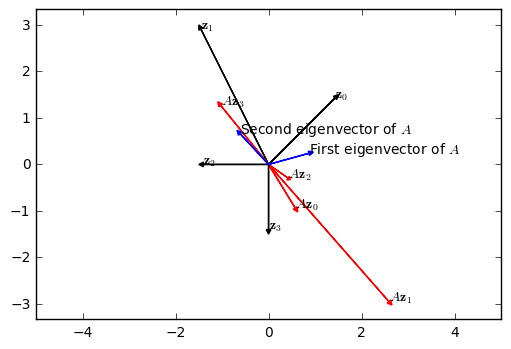

In [293]:
Z = 1.5*numpy.asarray([[1.0,-1.0,-1.0, 0.0],
                   [1.0, 2.0, 0.0,-1.0]])
numpy.random.seed(6)
A = numpy.random.randn(2,2)

illustrate_linear_transformation(A,Z)
l,W = numpy.linalg.eig(A)
draw_vector(W[:,0],'b',label='First eigenvector of $A$')
draw_vector(W[:,1],'b',label='Second eigenvector of $A$')
print "Eigenvectors"
print W
print "Eigenvalues"
print l

Winv = numpy.linalg.inv(W)
L = numpy.diag(l)
# A = W*diag(L)*W^{-1}
A - numpy.dot(numpy.dot(W,L),Winv)


# Multivariate Gaussian distribution

We will first consider a simple generalization of a Gaussian distribution to 2D
$$
\begin{aligned}
z_1 &\sim \Gaussian{0}{\sigma_1^2}\\
z_2 &\sim \Gaussian{0}{\sigma_2^2}
\end{aligned}
$$


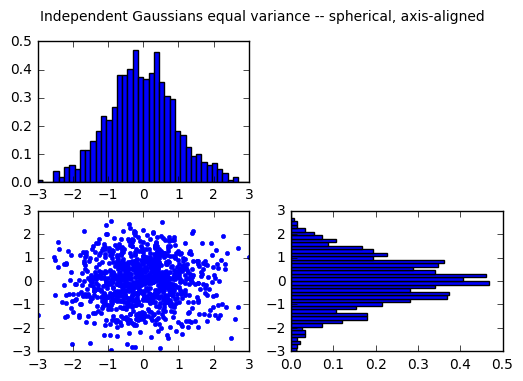

In [330]:
import matplotlib.pyplot as plt
sigma_1 = 1
sigma_2 = 1
bounds = [-3,3]
z1 = sigma_1*numpy.random.randn(1000)
z2 = sigma_2*numpy.random.randn(1000)

plt.subplot(2,2,1)
plt.hist(z1,range=bounds,bins=40,normed=True)
plt.subplot(2,2,4)
plt.hist(z2,range=bounds,bins=40,orientation='horizontal',normed=True)

plt.subplot(2,2,3)
plt.plot(z1,z2,'.')
plt.xlim(bounds)
plt.ylim(bounds)
plt.suptitle('Independent Gaussians equal variance -- spherical, axis-aligned');

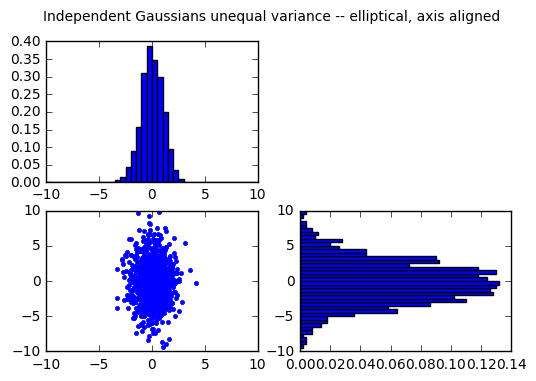

In [331]:
import matplotlib.pyplot as plt
sigma_1 = 1
sigma_2 = 3
bounds = [-10,10]
z1 = sigma_1*numpy.random.randn(1000)
z2 = sigma_2*numpy.random.randn(1000)

plt.subplot(2,2,1)
plt.hist(z1,range=bounds,bins=40,normed=True)
plt.subplot(2,2,4)
plt.hist(z2,range=bounds,bins=40,orientation='horizontal',normed=True)

plt.subplot(2,2,3)
plt.plot(z1,z2,'.')
plt.xlim(bounds)
plt.ylim(bounds)
plt.suptitle('Independent Gaussians unequal variance -- elliptical, axis aligned');

# Multivariate Gaussian distribution -- independent case

Since $z_1$ and $z_2$ are independent we can write out the joint 
$$
\begin{aligned}
p(z_1,z_2) &= p(z_1)p(z_2) \\
&= \frac{1}{\sqrt{2\pi\sigma_1^2} }
   \frac{1}{\sqrt{2\pi\sigma_2^2} }\myexp{-\frac{1}{2\sigma_1^2}z_1^2}\myexp{-\frac{1}{2\sigma_1^2}z_2^2}\\
&= \frac{1}{\sqrt{(2\pi)^2\sigma_1^2\sigma_2^2}}\myexp{ -\frac{1}{2\sigma_1^2}z_1^2  -\frac{1}{2\sigma_2^2}z_2^2}
\end{aligned}
$$

In fact, for multiple independent Gaussian random variables $z_1,...,z_n$ the joint is
$$
\begin{aligned}
p(z_1,\dots,z_n) &= \prod_i p(z_i) \\
&= (2\pi)^{-n/2}\left(\prod_{i=1}^n \sigma_i^2\right)^{-1/2}\myexp{-\sum_{i=1}^n \frac{1}{2\sigma_i^2}z_i^2}
\end{aligned}
$$

# Multivariate Gaussian distribution -- dependent case

Suppose we have $n$ standard random variables  (0 mean, unit variance)
$$
\begin{aligned}
z_i \sim& \Gaussian{0}{1},&  i=1,\dots n
\end{aligned}
$$
and we are given a vector $\mmu$ of length $n$ and a full-rank matrix $A$ of size $n \times n$.

What does distribution of $\xx = A\zz + \mmu$ look like?

Sample covariance:
[[ 1.04019881  0.50597955]
 [ 0.50597955  0.41709157]]
True covariance:
[[ 1.04  0.5 ]
 [ 0.5   0.41]]


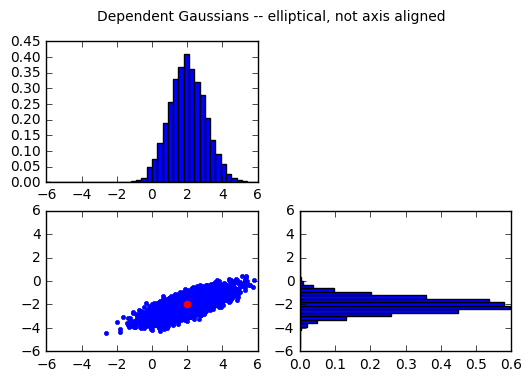

In [335]:
# independent 0 mean, unit variance
z1 = numpy.random.randn(10000)
z2 = numpy.random.randn(10000)

# matrix 2 x 2
A = numpy.asarray([[1,-0.2],[0.4,-0.5]])
# column vector (2 x 1)
mu = numpy.asarray([[2.0],[-2.0]])

z = numpy.vstack((z1,z2))
x = numpy.dot(A,z) + mu

bounds = [-6, 6]
plt.subplot(2,2,1)
plt.hist(x[0,:],range=bounds,bins=40,normed=True)
plt.subplot(2,2,4)
plt.hist(x[1,:],range=bounds,bins=40,orientation='horizontal',normed=True)

plt.subplot(2,2,3)
plt.plot(x[0,:],x[1,:],'.')
plt.xlim(bounds)
plt.ylim(bounds)
plt.plot(mu[0],mu[1],'r.',markersize=10)
plt.suptitle('Dependent Gaussians -- elliptical, not axis aligned')
print "Sample covariance:\n", numpy.cov(x) 
print "True covariance:\n", numpy.dot(A,A.transpose())

# Multivariate Gaussian distribution -- dependent case

Suppose we have $n$ standard random variables  (0 mean, unit variance)
$$
\begin{aligned}
z_i \sim& \Gaussian{0}{1},&  i=1,\dots n
\end{aligned}
$$
and we are given a vector $\mmu$ of length $n$ and a full-rank matrix $A$ of size $n \times n$.

Distribution of $\xx = A\zz + \mu$ is
$$
p(\xx) = \left(2\pi\right)^{-\frac{n}{2}}(\det{\Sigma})^{-\frac{1}{2}}\myexp{-\frac{1}{2}(\xx - \mmu)^T\Sigma^{-1}(\xx-\mmu)}
$$
where $\Sigma = AA^T$.

* $\mu$ is **mean** of the Gaussian
* $\Sigma$ is **covariance** matrix


# Multivariate Gaussian distributions -- covariance matrices

Typical covariance matrices:
* diagonal with constant diagonal -- data looks spherical and axis aligned
$$\Sigma = \sigma^2 I = \diag{\sigma \ones_n} = 
\begin{bmatrix} \sigma^2& 0& \dots  &0 &0\\
0 & \sigma^2 & \dots & 0 & 0\\
\vdots& \vdots & \ddots & \vdots & \vdots \\
0 & 0 & \dots & \sigma^2 & 0 \\
0 & 0 & \dots & 0 & \sigma^2 \\
\end{bmatrix}$$

* diagonal with non-constant diagonal -- data looks elliptical and axis aligned
$$\Sigma = \diag{\ssigma} = 
\begin{bmatrix} \sigma_1^2& 0& \dots  &0 &0\\
0 & \sigma_2^2 & \dots & 0 & 0\\
\vdots& \vdots & \ddots & \vdots & \vdots \\
0 & 0 & \dots & \sigma_{n-1}^2 & 0 \\
0 & 0 & \dots & 0 & \sigma_n^2 \\
\end{bmatrix}$$

* unconstrained -- data looks elliptical but rotated 



# Maximum likelihood estimates of mean and covariance

Given data $\{\xx_i \in \reals^n|i=1,\dots,T\}$ maximum likelihood estimates (MLE) of mean and covariance are:
$$
\begin{aligned}
\mmu^{\MLE} &= \frac{1}{T}\sum_{i=1}^T \xx_i\\
\Sigma^{\MLE} & = \frac{1}{T}\sum_{i=1}^T \underbrace{\left(\xx_i - \mmu^{\MLE}\right)\left(\xx_i - \mmu^{\MLE}\right)^T}_{\textrm{ a matrix of size $n \times n$}}
\end{aligned}
$$
Dimensionality
* $\mmu^{\MLE}$ is of same dimension as a single data point $n \times 1$.
* $\Sigma^{\MLE}$ is a matrix of size $n \times n$ 

Note that $\xx\xx^T$ and $\xx^T\xx$ are not the same. Former is a matrix, latter is a scalar.


# Multivariate Gaussian distribution

Multivariate Gaussian distribution underlies many machine learning techniques:
* Linear Discriminant Analysis and variants of Naive Bayes -- classification 
* Principal Component Analysis and Factor Analysis -- dimensionality reduction
* Mixture of Gaussians -- clustering
* Kalman filter -- sequential data denoising and prediction
* Graphical models for speech, images and video

Hence, we will see this several times over. In due course, we will introduce closed form expressions for constructing marginal, conditional, and joint distribution.


# Generative vs discriminative approaches to classification

Thus far, we posed classification problems in terms of learning conditional probabilities of labels $y$ given features $\xx$
$$
p(y\given \xx,\theta)
$$
and we optimized **conditional** log-likelihood
$$
\loglik(\theta|\yy,X) = \sum_i \log \underbrace{p(y_i \given \xx_i,\theta)}_{\textrm{conditional probability}}
$$

We did not care about how features $\xx$ were distributed.

Our aim was to increase probability of labels given features. 

This approach to learning is called **discriminative** -- we learn to discriminate between different classes.


# Generative vs discriminative approaches to classification

Generative models describe all of the data
$$
p(y,\xx\given \theta)
$$
and optimize **joint** log-likelihood
$$
\loglik(\theta\given\yy,X) = \sum_i \log \underbrace{p(y_i, \xx_i\given\theta)}_{\textrm{joint probability}}
 = \sum_i \left[\log \underbrace{p(y_i \given \xx_i,\theta)}_{\textrm{conditional probability}} + {\color{red}{\log \underbrace{p(\xx_i\given\theta)}_{\textrm{marginal probability}}}}\right]$$
 
In this setting, the log-likelihood can be improved by:
1. increasing conditional probability of labels given features $p(y_i\given\xx_i,\theta)$
2. increasing probability of features $p(\xx_i\given\theta)$

However, given such a model we can describe how the data as a whole -- both features and labels -- were generated.
This is particulary important if there is missing data.

This approach to learning is called **generative**.

# Generative models for classification 

There are two ways to factorize joint probability of labels and features
$$
p(y,\xx\given\theta) = p(y\given\xx,\theta)p(\xx\given\theta) =  p(\xx\given y,\theta)p(y\given\theta) 
$$

The second one given us a simple process to *GENERATE* data:

1. First select label according $p(y\given\theta)$, say it was $c$
2. Now generate features $p(\xx\given y=c,\theta)$

Once we have such a model we can obtain the conditional probability $p(y\given\xx)$ using Bayes rule
$$
p(y=c\given \xx) = \frac{p(y=c\given\theta)p(\xx\given y=c,\theta)}{\sum_k p(y=k\given\theta)p(\xx\given y=k,\theta)}
$$
and we can predict label for a new feature vector $\xx$ 

# Generative models for classification -- prediction

If we are only interested in predicting the most likely class -- rather than computing probabilities -- we can simplify math a bit by observing

$$
p(y=c\given \xx) = \frac{p(y=c\given\theta)p(\xx\given y=c,\theta)}{\underbrace{\sum_k p(y=k\given\theta)p(\xx\given y=k,\theta)}_{\textrm{does not depend on c}}}
$$
Hence
$$
p(y=c\given \xx) \propto p(y=c\given\theta)p(\xx\given y=c,\theta)
$$
and 
$$
\begin{aligned}
\mathop{\textrm{argmax}}_c p(y=c\given \xx) &= \mathop{\textrm{argmax}}_c p(y=c\given\theta)p(\xx\given y=c,\theta) \\
&=
\mathop{\textrm{argmax}}_c \log  p(y=c\given\theta) + \log p(\xx\given y=c,\theta)
\end{aligned}
$$


# An example of a generative model

Uniform prior on classes
$$
p(y=c) = \frac{1}{K}
$$
Gaussian distribution of features for each class, different means $\mmu_c$, but same covariance
$$
\xx\given y=c,\mmu,\sigma \sim \Gaussian{\mmu_c}{\Sigma}
$$

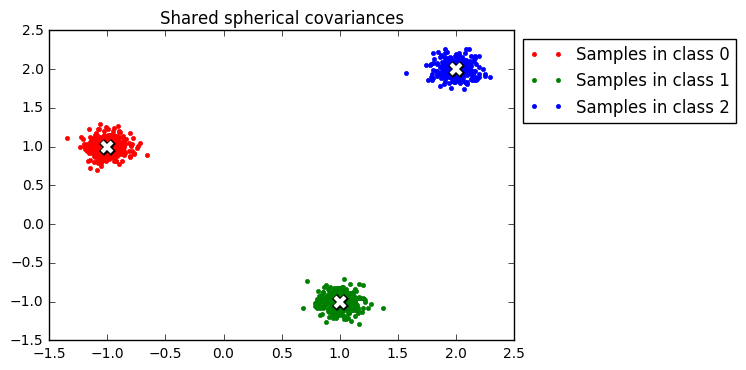

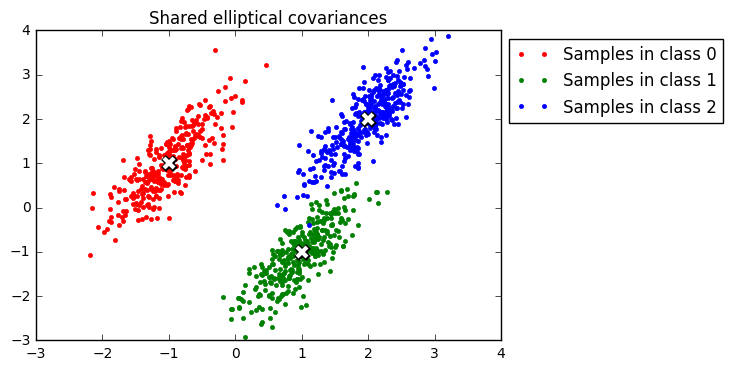

In [334]:
import numpy
import matplotlib.pyplot as plt

def generate_data(N,d,K,proby,mus,A):
    # This function will generate data from 
    # K Gaussians. Each Gaussian has different mean
    # mus[:,c] is mean for the c-th Gaussian
    # Covariance Sigma = A^T A is shared between 
    # Gaussians.
    
    ys = [0]*N
    xs = numpy.zeros((d,N))
    for i in range(N):
        # Sample class according to the prior p(y)
        # in this case it is uniform
        ys[i] = numpy.random.choice(K,1)      
        # Sample feature values according to p(x|y)
        # In this case, x ~ N(mmu[y[i]],sigma2*I)
        # To accomplish this, draw z1,z2 ~ N(0,I)    
        z = numpy.random.randn(2,1)
        # transform by matrix A and shift by class mean
        x = numpy.dot(A,z) + mus[:,ys[i]]  
        xs[:,i] = x[:,0]
    return xs,ys

def plot_samples(xs,ys,mus=None,colors=['r','g','b']):
    K = numpy.max(ys)+1
    colors = ['r','g','b']
    for c in range(K):
        # indices of samples assigned to class c
        ind = [i for i in range(N) if ys[i]==c]
        plt.plot(xs[0,ind],xs[1,ind],colors[c]+'.',label='Samples in class '+str(c))    
        if not mus is None:
            plt.plot(mus[0,c],mus[1,c],'kx',markersize=9,markeredgewidth=5)
            plt.plot(mus[0,c],mus[1,c],'wx',markersize=7,markeredgewidth=3)

    plt.legend(loc=2, bbox_to_anchor=(1,1))

N = 1000 # 100 samples
K = 3   # 3 classes
d = 2   # x is 2d 
proby = [1.0/K]*K # [1./3. , 1./3., 1./3.]
mus = 1.0*numpy.asarray([[-1.0,1.0,2],[1.0,-1.0,2.0]])
sigma = 0.1 # standard deviation, variance is 0.01
# A just scales each coordinate by sigma
A = sigma*numpy.eye(2)
xs,ys = generate_data(N,d,K,proby,mus,A)
plot_samples(xs,ys,mus)
plt.title('Shared spherical covariances')

plt.figure()
# this A scales and rotates 
numpy.random.seed(2)
A = numpy.random.rand(2,2)
xs,ys = generate_data(N,d,K,proby,mus,A)
plot_samples(xs,ys,mus)
plt.title('Shared elliptical covariances');





# Generative models for classification 

In order to specify a generative model we have to specify its parts
1. Prior probability for a label $p(y\given\theta)$
2. Probability for features in each of the classes $p(\xx\given y=1,\theta),...,p(\xx\given y=k,\theta)$.

Q: How would you specify probability of labels? What would be your guess? Can you learn that probability?  

Q: Let's say that we have $p$ features and $C$ classes give a guess about the number of parameters need to specify $p(\xx\given y,\theta)$.

# Generative models for classification 

We will make a simplifying assumptions about feature distribution
$$
p(\xx\given y,\theta) = \prod_j p(x_j \given y, \theta)
$$

Q: What does this say about features? Recall what it means to be able to factorize $p(x_1,x_2) = p(x_1)p(x_2)$

This assumption underlies the **Naive Bayes** method.

# Naive Bayes

$$
\begin{aligned}
p(y = c \given \pi ) &= \pi_k \\
p(\xx \given y=c, \theta) &= \prod_j p(x_j \given y= c,\theta_{j,c})
\end{aligned}
$$
Parameters are 
* $\pi_c$ prior probability that a sample comes from the class $c$
* $\theta_{j,c}$ parameters for the $j^\tth$ feature for class $c$

In general, there are many variants of Naive Bayes. 

You can choose different distributions for $p(x_j \given y = c)$
* Gaussian -- continuous features
* Bernoulli -- binary features
* Binomial -- count of positive outcomes
* Categorical -- discrete features
* Multinomial -- count of particular discrete outcomes

# Naive Bayes with Gaussian features

We will assume that 
$$
\begin{aligned}
x_j\given y_c, \theta &\sim \Gaussian{\theta_{j,c}}{\sigma^2}
\end{aligned}
$$
Each feature is Gaussian distributed around class specific mean and with shared spherical variance.

Let's take a look at the data we generated earlier and read-off these parameters.

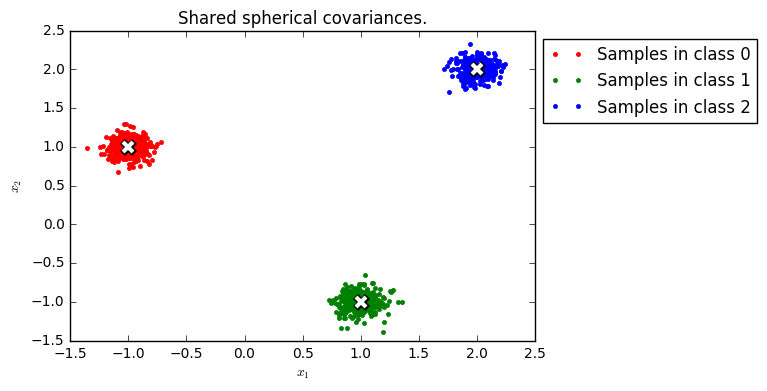

In [333]:

N = 1000 # 100 samples
K = 3   # 3 classes
d = 2   # x is 2d 
proby = [1.0/K]*K # [1./3. , 1./3., 1./3.]
mus = 1.0*numpy.asarray([[-1.0,1.0,2],[1.0,-1.0,2.0]])
sigma = 0.1 # standard deviation, variance is 0.01
# A just scales each coordinate by sigma
A = sigma*numpy.eye(2)
xs,ys = generate_data(N,d,K,proby,mus,A)
plot_samples(xs,ys,mus)
plt.title('Shared spherical covariances.');
plt.xlabel('$x_1$')
plt.ylabel('$x_2$');

# Learning parameters for Naive Bayes

In the synthetic data examples, we know the ground truth parameters -- after all, we generated the data.

Q: How do we go about learning parameters for a Naive Bayes model?

# Learning parameters for Naive Bayes

Log-likelihood
$$
\begin{aligned}
\loglik(\theta,\pi\given\yy,X) & = \sum_i \log p(y_i,\xx_i\given\theta,\pi)  && \textrm{definition of likelihood} \\
& = \sum_i \log p(y_i\given\pi) + \log p(\xx_i\given y_i,\theta) && \textrm{factorization } p(y,\xx) = p(y) p(\xx|y) \\
& = \sum_i \log p(y_i\given\pi) + \log \prod_j p(x_{j,i}\given y_i,\theta_j) && \textrm{ Naive Bayes assumption}\\
& = \sum_i \log p(y_i\given\pi) + \sum_j \log p(x_{j,i}\given y_i,\theta_j)
\end{aligned}
$$

Note that we have not yet used our assumptions about distribution of $x_{j,i}$.





# Learning parameters for Naive Bayes with Gaussian features

Log-likelihood
$$
\begin{aligned}
\loglik(\theta,\pi\given\yy,X)  &= \sum_i \left[\log p(y_i\given\pi) + \sum_j \log p(x_{j,i}\given y_i,\theta_j) \right]\\
& = \sum_i \left[\log \pi_{\color{red}{y_i}} + \sum_j \log \frac{1}{\sqrt{2\pi\sigma^2}}\myexp{-\frac{1}{2\sigma^2}(x_{j,i} - \theta_{j,\color{red}{y_i}})^2}\right]
\end{aligned}
$$
Note that parameters $\pi_c$ and $\theta_{i,c}$ are only used for samples that belong to class $c$ ($y_i=c$)

Hence, we can learn of parameters for each class separately.

# Learning parameters for Naive Bayes with Gaussian features

Closed form MLE for parameters are
$$
\begin{aligned}
\pi_k &= \frac{\sum_i [y_i = k]}{\sum_i 1} && \textrm{frequency of class $k$ in training data}\\
\theta_{j,k} &= \frac{\sum_i [y_i = k]x_{i,j}}{\sum_i 1} && \textrm{average of feature $j$ among samples in class $k$}\\
\sigma &= \frac{\sum_i (x_{j,i} - \theta_{j,y_i})^2}{\sum_i 1} && \textrm{variance across all features}
\end{aligned}
$$

We will work this out on board, if there is time. Otherwise, next lecture.

# Class prediction using Naive Bayes with Gaussian features
Recall that 
$$
\mathop{\textrm{argmax}}_c p(y=c\given \xx) = 
\mathop{\textrm{argmax}}_c \log  p(y=c\given\theta) + \log p(\xx\given y=c,\theta)
$$

After a little bit more manipulation
$$
\begin{aligned}
\log p(y=k \given \xx,\theta,\pi) 
&= \log \pi_{k} - \sum_j \frac{1}{2\sigma^2}(x_{j,i} - \theta_{j,k})^2 + \textrm{const.} 
\end{aligned}
$$
Predicted class
$$
y^* = \mathop{\textrm{argmax}}_k \log \pi_{k} - \underbrace{\sum_j (x_{j,i} - \theta_{j,k})^2}_{\textrm{distance to class center}} + \textrm{const.}
$$

# Today

* An example of online learning
* Linear Transformations review
* Multivariate Gaussian Distribution
* Generative vs Discriminative models
* Naive Bayes
